In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [2]:
def data_loader(data, batch_size, random_seed=123, valid_size=0.1, shuffle=True,test=False):
    normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),normalise])
    transform_train = transforms.Compose(
        [
        transforms.RandomRotation(5),
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         normalise])
    if test:
        dataset = datasets.Flowers102(root=data, split="test", download=True, transform=transform)
        data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
        print(f"Number of test examples: {len(dataset)}")
        return data_loader
    train_dataset = datasets.Flowers102(root=data, split="train", download=True, transform=transform_train)
    validation_dataset = datasets.Flowers102(root=data, split="val", download=True, transform=transform)
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    # train_idx, valid_idx = indices[split:], indices[:split]
    # train_sampler = torch.utils.data.sampler.SubsetRandomSampler(1020)
    # valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(1020)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
    print(f"Number of training examples: {len(train_dataset)}")
    return (train_loader, valid_loader)

train_loader, valid_loader = data_loader(data='flowers', batch_size=4, shuffle=True, test=False)
test_loader = data_loader(data='flowers', batch_size=4, shuffle=True, test=True)
# normalise = transforms.Normalize(mean=[0.4914,0.4822,0.4465],std=[0.2023,0.1994,0.2010])
# transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalise])
# transform_train = transforms.Compose(
#     [transforms.Resize((256,256)),
#      transforms.RandomHorizontalFlip(),
#      transforms.RandomVerticalFlip(p=0.5),
#      transforms.CenterCrop(224),
#      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.4, hue=0.1),
#      transforms.RandomRotation(10),
# #      transforms.ToTensor(),
# #      normalise])
# train_dataset = datasets.Flowers102(root='./data', split="train", download=True, transform=transform_train)
# validation_dataset = datasets.Flowers102(root="./data/", split="val", download=True, transform=transform)
# test = datasets.Flowers102(root="./data", split="test", download=True, transform=transform)
# train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
# valid_loader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(dataset=test, batch_size=32, shuffle=False)


Number of training examples: 1020
Number of test examples: 6149


In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class Rn(nn.Module):
    def __init__(self, block, layers, num_classes=102):
        super(Rn, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_planes, out_channels=planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
    

In [5]:
def count_parameters(model)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

NameError: name 'model' is not defined

In [6]:
import requests
def post_discord(epoch,train_loss, val_accuracy):
    data = {
        "username": "Flower Classifier"
    }
    data["embeds"] = [
        {
            "title": "Epoch {} Results".format(epoch),
            "color": 0x00ff00,
            "fields": [
                {
                    "name": "Training Loss",
                    "value": f"{train_loss}",
                    "inline": False
                },
                {
                    "name": "Validation Accuracy",
                    "value": f"{val_accuracy}",
                    "inline": False
                },
            ]
        }
    ]
    r = requests.post("https://discord.com/api/webhooks/1052587856343867392/SnR2U4HIdeF6ShECr0k1Mit6yrl3HgjtCMk_LykGD8eQ1qsZViY8HLeYsoBUXOHYfbgP", json=data)
    print(r.status_code)


In [9]:
import gc

def train(model, config, num_epochs):
    if torch.cuda.is_available():
      if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9, weight_decay=config["weight_decay"])
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            gc.collect()
        
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
        
        if epoch % 5 == 0:
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                total = 0
                correctT = 0
                totalT = 0
                for images, labels in valid_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted==labels).sum().item()
                for images, labels in train_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    totalT += labels.size(0)
                    correctT += (predicted==labels).sum().item()

                print('Training Accuracy accross {} images: {} %'.format(totalT, 100 * correctT / totalT))
                print('Validation Accuracy accross {} images: {} %'.format(total, 100 * correct / total))
                #post_discord(epoch+1, '{:.4f}'.format(loss.item()), 100 * correct / total)
        total = 0
        correct = 0
        if epoch % 100 == 0 and epoch != 0:
            with torch.no_grad():
                
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.cpu().numpy()
                    val_steps += 1
                    del images, labels, outputs
            torch.save(model.state_dict(), 'model-{}.pth'.format(100 * correct / total))

In [ ]:
torch.save(best.state_dict(), 'hey.pth')

In [7]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))   
        return correct / total


In [10]:
num_classes = 102
print_every = 5
total_step = len(train_loader)
historical_acc = []
bestModel = {"learning_rate": 0,
             "weight_decay": 0,
}
bestAccuracy = 0

for trials in range (20):
    num_epochs = 60
    config = {
        "learning_rate": np.power(10, np.random.uniform(-5, -3)),
        "weight_decay": np.power(10, np.random.uniform(-5, -3)),
    }
    print(config)
    model = Rn(Block, [2,2,2,2], num_classes).to(device)
    train(model, config, num_epochs)
    acc = test(model)
    if acc > bestAccuracy:
        bestModel = config
        bestAccuracy = acc
    toappend = [config, acc]
    historical_acc.append(toappend)

print(bestModel)
num_epochs = 300
model = Rn(Block, [2,2,2,2], num_classes).to(device)
train(model, bestModel)
test(model)


{'learning_rate': 3.4912718997841605e-05, 'weight_decay': 9.299070644685586e-05}
Epoch [1/60], Loss: 4.2657
Training Accuracy accross 1020 images: 1.9607843137254901 %
Validation Accuracy accross 1020 images: 1.6666666666666667 %
Epoch [2/60], Loss: 4.5419
Epoch [3/60], Loss: 4.7673
Epoch [4/60], Loss: 4.5188
Epoch [5/60], Loss: 4.3921
Epoch [6/60], Loss: 4.4190
Training Accuracy accross 1020 images: 10.490196078431373 %
Validation Accuracy accross 1020 images: 8.235294117647058 %
Epoch [7/60], Loss: 4.2176
Epoch [8/60], Loss: 3.8228
Epoch [9/60], Loss: 4.1158
Epoch [10/60], Loss: 4.8042
Epoch [11/60], Loss: 4.2003
Training Accuracy accross 1020 images: 13.431372549019608 %
Validation Accuracy accross 1020 images: 11.568627450980392 %
Epoch [12/60], Loss: 3.9861
Epoch [13/60], Loss: 4.0253
Epoch [14/60], Loss: 3.4087
Epoch [15/60], Loss: 4.2478
Epoch [16/60], Loss: 4.1401
Training Accuracy accross 1020 images: 12.647058823529411 %
Validation Accuracy accross 1020 images: 13.03921568627

TypeError: train() missing 1 required positional argument: 'num_epochs'

In [14]:
print(historical_acc)
print(bestModel)
for i in historical_acc:
    if i[0]["learning_rate"] == bestModel["learning_rate"] and i[0]["weight_decay"] == bestModel["weight_decay"]:
        print(i)
        break


[[{'learning_rate': 3.4912718997841605e-05, 'weight_decay': 9.299070644685586e-05}, 0.1888111888111888], [{'learning_rate': 4.7506629855179794e-05, 'weight_decay': 0.0003534045524050074}, 0.22101154659294195], [{'learning_rate': 8.954744837227782e-05, 'weight_decay': 0.0005504793206674897}, 0.29744673930720444], [{'learning_rate': 0.0009807617056922422, 'weight_decay': 2.7521487294829985e-05}, 0.40624491787282485], [{'learning_rate': 0.00016724099947851916, 'weight_decay': 0.0004954554626088196}, 0.3538786794600748], [{'learning_rate': 0.0007770934884978542, 'weight_decay': 3.8034074259808056e-05}, 0.3870548056594568], [{'learning_rate': 0.00028450210752363464, 'weight_decay': 1.0715989930291668e-05}, 0.39713774597495527], [{'learning_rate': 0.0005731718815316336, 'weight_decay': 1.3423850234464173e-05}, 0.389494226703529], [{'learning_rate': 0.0002929481753661239, 'weight_decay': 0.0009754854000035698}, 0.4039681248983575], [{'learning_rate': 0.00010054941809909967, 'weight_decay': 2.

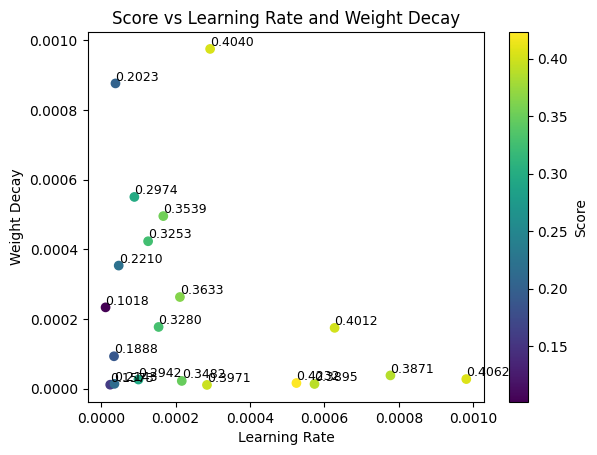

In [17]:
import matplotlib.pyplot as plt
# Extract x (learning_rate) and y (weight_decay) coordinates, and the corresponding scores
x = [point[0]['learning_rate'] for point in historical_acc]
y = [point[0]['weight_decay'] for point in historical_acc]
scores = [point[1] for point in historical_acc]

# Create a scatter plot
plt.scatter(x, y, c=scores, cmap='viridis')

# Add colorbar to show scores
cbar = plt.colorbar()
cbar.set_label('Score')

# Add the exact scores (rounded to 2 decimal places) as text next to each point
for i, score in enumerate(scores):
    plt.text(x[i], y[i], f"{score:.3f}", fontsize=9, verticalalignment='bottom', horizontalalignment='left')

# Label axes
plt.xlabel('Learning Rate')
plt.ylabel('Weight Decay')

# Set the title
plt.title('Score vs Learning Rate and Weight Decay')

# Show the plot
plt.show()

In [ ]:
def count_parameters(model)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

In [ ]:
print(model)